# Developed by: Michael Akinosho
# Created on: January 19th, 2022
# See section below for credit to source of data and scientific paper listed UCI's repository

In [134]:
# Mounting Google Drive
# Adding error handling when running Colab notebook locally
# Adding cell notebook when ran locally on a machine with 32 GB of RAM and i9 Processor
# If running, run as standard Colab file please provide path to file in the try block
try:
    from google.colab import drive
    drive.mount('/content/drive')
    filepath = "/content/drive/Othercomputers/My Laptop/diabetes_readmission/"
    msg = "Using Google Colab runtime, connection and resources"
except ModuleNotFoundError:
    filepath = 'C:\\Users\\micha\\Documents\\GitHub\\diabetes_readmission\\'
    msg = "Using local machine runtime, connection and resources"

print(msg)
filename = 'diabetes_balanced.csv'    
filepathname = filepath + filename

Using local machine runtime, connection and resources


In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [136]:
plt.style.use('seaborn-deep')

In [137]:
df = pd.read_csv(filepathname, header=0, index_col = 'encounter_id')
df.head(1)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,...,No,Steady,No,No,No,No,No,Ch,Yes,<30


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33357 entries, 36900 to 72865320
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               33357 non-null  int64 
 1   race                      33357 non-null  object
 2   gender                    33357 non-null  object
 3   age                       33357 non-null  object
 4   weight                    33357 non-null  object
 5   admission_type_id         33357 non-null  int64 
 6   discharge_disposition_id  33357 non-null  int64 
 7   admission_source_id       33357 non-null  int64 
 8   time_in_hospital          33357 non-null  int64 
 9   payer_code                33357 non-null  object
 10  medical_specialty         33357 non-null  object
 11  num_lab_procedures        33357 non-null  int64 
 12  num_procedures            33357 non-null  int64 
 13  num_medications           33357 non-null  int64 
 14  number_outpatie

# Problem Statement: Classify Encounters into readmitted  <30 (<=30), >30 and NO. This project is going to model the classification of patient readmissions into the following three classes:
*   Within 30 days (30th day inclusive) "<30" or "(<=30)"
*   From 31 days ">30"
*   Not readmitted "NO"

All encounters have a diagnosis of diabetes which is based on the clinical analysis of the patient's HbA1c or A1C test.

The American Diabetes Association (ADA) considers this relatively simple blood test a POWERHOUSE!! Some key bullets from their website: [ADA/A1C](https://diabetes.org/a1c)
* The test provides a picture of a person's blood sugar level over two to three months.
* The higher the levels, the greater a person's risk of developing diabetes complications.
* It can identify prediabetes, which raises the risk of diabetes.
* It can be used to diagnose diabetes.
* And, it's used to monitor how well the diabetes treatment is working over time.

The A1C feature in our dataset is very important, but it not enough by itself to help classify encounters into readmitted classes.

Throughout this project, I will continuously revisit this Problem Statement to ensure the model developed is built to help solve it.


# Start of Section on Functions

In [139]:
# Helper function that will show normalized value counts for features
def show_column_values():
    for feature in df.columns:
        print("Name of Feature:", feature)
        print(df[feature].value_counts(normalize=True))
        print("\n")

In [140]:
# Helper function to generate specific univariate plots
def create_plots(myXaxis,myYaxis,myXlabel,myYlabel,myTitle,myPlot,fsize=7):
    
    fig, notch_ax = plt.subplots(1, 1, figsize = (fsize,fsize))
    if myPlot == "Boxplot":
        sns.boxplot(ax = notch_ax,x = myXaxis, y = myYaxis, data = df,notch=True)
    elif myPlot == "Barplot":
        df_sub = df.groupby([myXaxis],as_index=False)[[myYaxis]].count()
        sns.barplot(ax = notch_ax, data = df_sub, x = myXaxis, y = myYaxis,edgecolor='black')
    elif myPlot == "Heatmap":
        sns.heatmap(ax = notch_ax, data=df.corr(),annot=True)
    elif myPlot == "Histplot":
        sns.histplot(data=df, x = myXaxis,bins=30)

    plt.title(myTitle)
    plt.xlabel(myXlabel)
    plt.ylabel(myYlabel)

    # Heatmap does not need to have y axis label formatted
    if myPlot != "Heatmap":
        plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()

# Start of Requirements Definition




In [141]:
df.shape

(33357, 49)

In [142]:
df.nunique()

patient_nbr                 24913
race                            6
gender                          2
age                            10
weight                         10
admission_type_id               7
discharge_disposition_id       23
admission_source_id            12
time_in_hospital               14
payer_code                     17
medical_specialty              65
num_lab_procedures            114
num_procedures                  7
num_medications                70
number_outpatient              24
number_emergency               25
number_inpatient               20
diag_1                        593
diag_2                        570
diag_3                        636
number_diagnoses               16
max_glu_serum                   4
A1Cresult                       4
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  4
glimepiride                     4
acetohexamide                   2
glipizide     

##Identify and delete unnecessary columns

In [143]:
# Inspect the columns that need to be dropped
show_column_values()

Name of Feature: patient_nbr
88785891    0.00069
1660293     0.00066
43140906    0.00066
23643405    0.00063
3401055     0.00054
             ...   
6612768     0.00003
75809547    0.00003
23384124    0.00003
90123669    0.00003
2868030     0.00003
Name: patient_nbr, Length: 24913, dtype: float64


Name of Feature: race
Caucasian          0.736787
AfricanAmerican    0.204695
Hispanic           0.021825
?                  0.018467
Other              0.013311
Asian              0.004917
Name: race, dtype: float64


Name of Feature: gender
Female    0.536739
Male      0.463261
Name: gender, dtype: float64


Name of Feature: age
[70-80)     0.267170
[60-70)     0.216296
[50-60)     0.169440
[80-90)     0.149204
[40-50)     0.102018
[30-40)     0.041670
[90-100)    0.021884
[20-30)     0.017837
[10-20)     0.011032
[0-10)      0.003448
Name: age, dtype: float64


Name of Feature: weight
?            0.962826
[75-100)     0.016338
[50-75)      0.010373
[100-125)    0.006326
[125-150)    0.00

This section attempts to explain the reasons for dropping some of the columns from the initial dataframe.
The reasons are:

After exploring the dataframe and reading the [Beata et al article](https://www.hindawi.com/journals/bmri/2014/781670/), and these four columns (weight, payer_code, medical_specialty and patient_nbr) are dropped:
1. weight: Over 97% of the records are missing the weight value
2. payer_code: Over 40% of the records are missing the payor code, payers don't make the decision on when to admit
3. medical_specialty: Over 49% of the records are missing the specialty value, specialty is not making the decision to admit. It is based on the clinical findings which are determined from the assessment of the health team
4. patient_nbr: not reliable enough to use and since it is an integer, the model might give higher patient_nbr a higher weight/value
5. The following columns are also dropped because they don't support variance explanation:
    * admission_type_id; values such as Emergency, Urgent, Elective, Newborn and Trauma Center won't help in classifying the readmitted target
    * admission_source_id; the 26 unique values won't help in classifying the readmitted target, grouping these values into clusters won't improve the model
6. The following columns are dropped because the numeric values assigned within each feature will not improve the classification model's performance, these features are more related to other diagnoses, which we account for in the number_diagnoses (co-morbidity) feature:
    * num_lab_procedures
    * num_procedures
    * num_medications
7. The following columns would make the model unnecessarily complex, the values reported are ICD9 (International Classification of Diseases and Procedures) codes used by hospitals to code diagnoses and procedures, including these columns as features would require significant pre-work to evaluate the ICD9 codes and convert these codes into values which represent some weight in terms of high-risk for readmission, a separate project on its own:
    * diag_1
    * diag_2
    * diag_3
8. All the medications listed as columns are also dropped except insulin.

In [144]:
features_included = ['race','gender','age','discharge_disposition_id',
                     'time_in_hospital','number_outpatient',
                     'number_emergency','number_inpatient',
                     'number_diagnoses','diag_1','diag_2','diag_3','max_glu_serum','A1Cresult',
                     'insulin','change','diabetesMed','readmitted']

In [145]:
# Resetting dataframe df to columns to be used as features and target
# Columns not in the list features_included will be dropped
df = df[features_included]

In [146]:
df.shape # Dropped 44 columns

(33357, 18)

##Identify and delete rows with invalid or inappropriate values

This section attempts to explain the reasons and approaches to dropping rows with invalid values.
* Based on the [Beata et al article](https://www.hindawi.com/journals/bmri/2014/781670/), excluding records where the discharge disposition is expired or discharged to hospice, will eliminate bias.
* The approach taken by the authors is correct, it would be nonsensical to build the model with records of patients that have expired.
* One might ask why not have the model predict that these patients should be classified in the "NO" class.
* The problem with the statement above is that some in the "NO" class may neither be expired nor transferred to hospice.
* The model needs to learn well how to clarify the "NO" class without bias from records we know will not be readmitted at all.
* Within discharge disposition NULL (NaN), Not Mapped, Unknown/Invalid are also dropped.

In [147]:
# Dropping rows with readmitted value of "NO"
# The driving reason for this is to minimize or reduce the Type 2 error rate or False Negatives
# Patients who will be flagged as readmitted after 30 days
# But have a high probability of being readmitted within 30 days

#num_rows = 0
#missing_values = ['readmitted']
#for feature in missing_values:
#    for id in ['NO']:
#        df_filter = df[df[feature] == id]
#        num_rows += df_filter.shape[0]
#        print("Number of rows to be dropped: {:,.0f} with value of {} in feature {}".format(df_filter.shape[0],id,feature))
#        df.drop(df_filter.index, inplace = True)
#    print("Total number of rows deleted: {:,.0f}".format(num_rows))
#    print("Number of rows in dataframe after rows are deleted: {:,.0f}\n".format(df.shape[0]))
#    num_rows = 0

In [148]:
dischargefile = filepath + "discharge_disposition.csv"
discharge_df = pd.read_csv(dischargefile)
discharge_df

,discharge_disposition_id,description,Cluster
0,1,Discharged to home,Home
1,2,Discharged/transferred to another short term h...,Care Facility
2,3,Discharged/transferred to SNF,Care Facility
3,4,Discharged/transferred to ICF,Care Facility
4,5,Discharged/transferred to another type of inpa...,Care Facility
5,6,Discharged/transferred to home with home healt...,Home
6,7,Left AMA,AMA
7,8,Discharged/transferred to home under care of H...,Home
8,9,Admitted as an inpatient to this hospital,Care Facility
9,10,Neonate discharged to another hospital for neo...,Care Facility


In [149]:
expired_discharge_df = discharge_df.loc[discharge_df['Cluster']=='Expired']
print(expired_discharge_df.shape)
expired_discharge_df

(9, 3)


,discharge_disposition_id,description,Cluster
10,11,Expired,Expired
12,13,Hospice / home,Expired
13,14,Hospice / medical facility,Expired
17,18,NaN,Expired
18,19,"Expired at home. Medicaid only, hospice.",Expired
19,20,"Expired in a medical facility. Medicaid only, ...",Expired
20,21,"Expired, place unknown. Medicaid only, hospice.",Expired
24,25,Not Mapped,Expired
25,26,Unknown/Invalid,Expired


In [150]:
# Dropping rows with discharge disposition of expired or discharged to hospice
num_rows = 0
missing_values = ['discharge_disposition_id']
for feature in missing_values:
    for id in [11,13,14,18,19,20,21,25,26]:
        df_filter = df[df[feature] == id]
        num_rows += df_filter.shape[0]
        print("Number of rows to be dropped: {:,.0f} with value of {} in feature {}".format(df_filter.shape[0],id,feature))
        df.drop(df_filter.index, inplace = True)
    print("Total number of rows deleted: {:,.0f}".format(num_rows))
    print("Number of rows in dataframe after rows are deleted: {:,.0f}\n".format(df.shape[0]))
    num_rows = 0


Number of rows to be dropped: 329 with value of 11 in feature discharge_disposition_id
Number of rows to be dropped: 29 with value of 13 in feature discharge_disposition_id
Number of rows to be dropped: 64 with value of 14 in feature discharge_disposition_id
Number of rows to be dropped: 3,668 with value of 18 in feature discharge_disposition_id
Number of rows to be dropped: 0 with value of 19 in feature discharge_disposition_id
Number of rows to be dropped: 0 with value of 20 in feature discharge_disposition_id
Number of rows to be dropped: 0 with value of 21 in feature discharge_disposition_id
Number of rows to be dropped: 765 with value of 25 in feature discharge_disposition_id
Number of rows to be dropped: 0 with value of 26 in feature discharge_disposition_id
Total number of rows deleted: 4,855
Number of rows in dataframe after rows are deleted: 28,502



The race and gender features contain rows with invalid values.
* race feature has about 2% of rows with a value of "?".
* It is appropriate to delete these rows.
* Instead of assuming the most frequent race would be the value appropriate
* gender feature also has rows with a value of "Unknown/Invalid".
* The count of rows is deemed statistical insignificant.
* And it is appropriate to delete.

In [151]:
# Dropping rows with inappropriate values
num_rows = 0
missing_values = ['race','gender','diag_1','diag_2','diag_3']
for feature in missing_values:
    for id in ["?","Unknown/Invalid"]:
        df_filter = df[df[feature] == id]
        num_rows += df_filter.shape[0]
        print("Number of rows to be dropped: {:,.0f} with value of {} in feature {}".format(df_filter.shape[0],id,feature))
        df.drop(df_filter.index, inplace = True)
    print("Total number of rows deleted: {:,.0f}".format(num_rows))
    print("Number of rows in dataframe after rows are deleted: {:,.0f}\n".format(df.shape[0]))
    num_rows = 0

Number of rows to be dropped: 576 with value of ? in feature race
Number of rows to be dropped: 0 with value of Unknown/Invalid in feature race
Total number of rows deleted: 576
Number of rows in dataframe after rows are deleted: 27,926

Number of rows to be dropped: 0 with value of ? in feature gender
Number of rows to be dropped: 0 with value of Unknown/Invalid in feature gender
Total number of rows deleted: 0
Number of rows in dataframe after rows are deleted: 27,926

Number of rows to be dropped: 9 with value of ? in feature diag_1
Number of rows to be dropped: 0 with value of Unknown/Invalid in feature diag_1
Total number of rows deleted: 9
Number of rows in dataframe after rows are deleted: 27,917

Number of rows to be dropped: 143 with value of ? in feature diag_2
Number of rows to be dropped: 0 with value of Unknown/Invalid in feature diag_2
Total number of rows deleted: 143
Number of rows in dataframe after rows are deleted: 27,774

Number of rows to be dropped: 482 with value

## Creating clusters for the following five features, all have integer values with over 20 unique values in each feature.
### Clustering and grouping will minimize the impact of outliers.
### Changing the values to categorical values would make the model inefficient.
### For the discharge_disposition, clusters have been identified based on the description of the value, see discharge_df above.
### For these four features below:
    * number_outpatient - number of outpatient visits of patient in the year preceding the encounter
    * number_emergency - number of emergency visits of patient in the year preceding the encounter
    * number_inpatient - number of inpatient visits(admissions) in the year preceding the encounter
    * number_diagnoses - number of diagnoses entered into the system
### Numeric values of 10 or greater than will be grouped under 10, more diagnoses or visits will not necessarily improve the classification performance of the model. These values are already high values for these kinds of features.

In [152]:
discharge_disposition_dict = dict()
for x in range(0,discharge_df.shape[0]):
    print(discharge_df.loc[x]['discharge_disposition_id'], discharge_df.loc[x]['Cluster'])
    discharge_disposition_dict.update({discharge_df.loc[x]['discharge_disposition_id']: discharge_df.loc[x]['Cluster']})

1 Home
2 Care Facility
3 Care Facility
4 Care Facility
5 Care Facility
6 Home
7 AMA
8 Home
9 Care Facility
10 Care Facility
11 Expired
12 Care Facility
13 Expired
14 Expired
15 Care Facility
16 Care Facility
17 Home
18 Expired
19 Expired
20 Expired
21 Expired
22 Care Facility
23 Care Facility
24 Care Facility
25 Expired
26 Expired
30 Care Facility
27 Care Facility
28 Care Facility
29 Care Facility


In [153]:
# Creating the discharge disposition groups
# Once groups are created, drop previous discharge disposition column
df['discharge_group'] = df['discharge_disposition_id'].map(discharge_disposition_dict)
df.drop(columns='discharge_disposition_id', inplace=True)

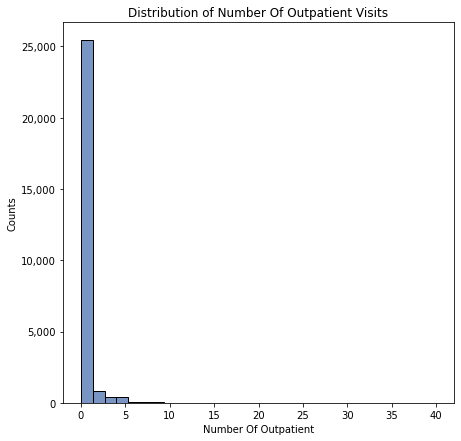

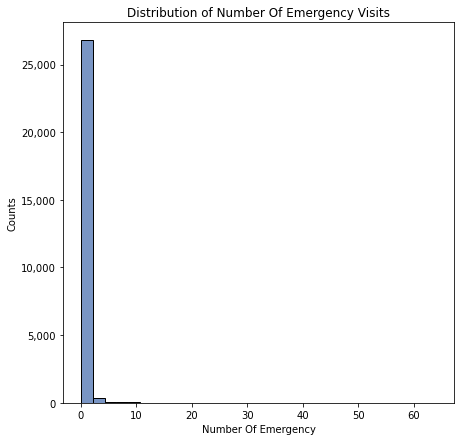

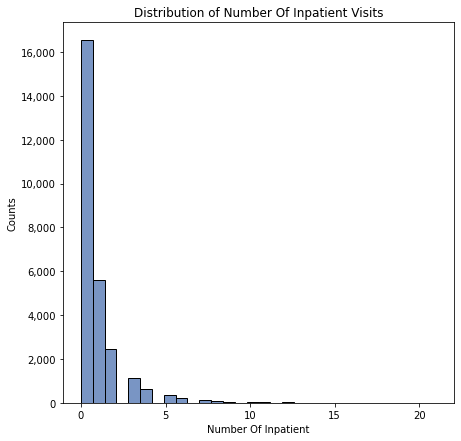

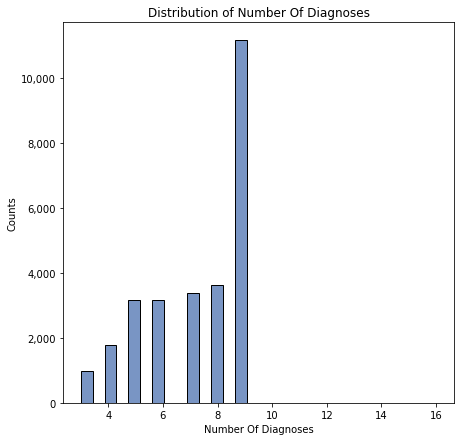

In [154]:
# Creating visualizations of features with outliers
# Create a number of Histplots
histplot_features_list = ['number_outpatient',
                          'number_emergency','number_inpatient']
for plot in histplot_features_list:
    plotLbl = plot.replace("number_","number of ")
    plotLbl = plotLbl.title()
    create_plots(plot,'blank',
                 plotLbl,'Counts',
                 'Distribution of ' + plotLbl + ' Visits','Histplot')

histplot_features_list = ['number_diagnoses']
for plot in histplot_features_list:
    plotLbl = plot.replace("number_","number of ")
    plotLbl = plotLbl.title()
    create_plots(plot,'blank',
                 plotLbl,'Counts',
                 'Distribution of ' + plotLbl ,'Histplot')

In [155]:
# Creating the clusters for visits and diagnoses features
# Once cluster is created drop previous field
df['num_of_outpatient'] = [10 if x >= 10 else x for x in df['number_outpatient']]
df.drop(columns='number_outpatient',inplace=True)

df['num_of_emergency'] = [10 if x >= 10 else x for x in df['number_emergency']]
df.drop(columns='number_emergency',inplace=True)

df['num_of_inpatient'] = [10 if x >= 10 else x for x in df['number_inpatient']]
df.drop(columns='number_inpatient',inplace=True)

df['num_of_diagnoses'] = [10 if x >= 10 else x for x in df['number_diagnoses']]
df.drop(columns='number_diagnoses',inplace=True)

In [156]:
# Inspect the features for rows that need to be deleted
# An imputer is not going to appropriate for this rows
show_column_values()

Name of Feature: race
Caucasian          0.759233
AfricanAmerican    0.201451
Hispanic           0.020849
Other              0.013301
Asian              0.005166
Name: race, dtype: float64


Name of Feature: gender
Female    0.539609
Male      0.460391
Name: gender, dtype: float64


Name of Feature: age
[70-80)     0.267258
[60-70)     0.217646
[50-60)     0.170233
[80-90)     0.152572
[40-50)     0.101532
[30-40)     0.042393
[90-100)    0.022168
[20-30)     0.017514
[10-20)     0.007255
[0-10)      0.001429
Name: age, dtype: float64


Name of Feature: time_in_hospital
3     0.164590
2     0.159387
4     0.141543
1     0.117104
5     0.102338
6     0.078668
7     0.062216
8     0.050308
9     0.033783
10    0.027810
11    0.020043
12    0.016525
13    0.013227
14    0.012458
Name: time_in_hospital, dtype: float64


Name of Feature: diag_1
428    0.078375
414    0.075553
786    0.039902
410    0.037923
486    0.029899
         ...   
V60    0.000037
353    0.000037
217    0.000037
647 

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27292 entries, 36900 to 72865320
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   race               27292 non-null  object
 1   gender             27292 non-null  object
 2   age                27292 non-null  object
 3   time_in_hospital   27292 non-null  int64 
 4   diag_1             27292 non-null  object
 5   diag_2             27292 non-null  object
 6   diag_3             27292 non-null  object
 7   max_glu_serum      27292 non-null  object
 8   A1Cresult          27292 non-null  object
 9   insulin            27292 non-null  object
 10  change             27292 non-null  object
 11  diabetesMed        27292 non-null  object
 12  readmitted         27292 non-null  object
 13  discharge_group    27292 non-null  object
 14  num_of_outpatient  27292 non-null  int64 
 15  num_of_emergency   27292 non-null  int64 
 16  num_of_inpatient   27292 non-null

In [158]:
# Check for the existence of duplicate records
df.duplicated().sum()

7

In [159]:
df.loc[df.duplicated(keep=False)]

,race,gender,age,time_in_hospital,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted,discharge_group,num_of_outpatient,num_of_emergency,num_of_inpatient,num_of_diagnoses
encounter_id,,,,,,,,,,,,,,,,,,
138307110,Caucasian,Male,[60-70),1,414,250,401,None,None,No,No,Yes,<30,Home,0,0,0,6
250053312,Caucasian,Male,[60-70),1,414,250,401,None,None,No,No,Yes,<30,Home,0,0,0,6
3616560,Caucasian,Male,[70-80),4,574,401,250,Norm,None,No,No,No,NO,Home,0,0,0,3
5351838,Caucasian,Male,[60-70),2,414,401,250,None,None,No,No,Yes,NO,Home,0,0,0,5
19904172,Caucasian,Male,[60-70),1,414,411,401,None,None,No,No,Yes,NO,Home,0,0,0,6
26247546,Caucasian,Male,[60-70),1,414,411,401,None,None,No,No,Yes,NO,Home,0,0,0,6
26452536,Caucasian,Male,[60-70),2,414,401,250,None,None,No,No,Yes,NO,Home,0,0,0,5
32019594,Caucasian,Female,[60-70),2,414,401,250,None,None,No,No,No,NO,Home,0,0,0,5
35747160,Caucasian,Female,[70-80),2,786,401,250,None,None,No,No,Yes,NO,Home,0,0,0,5


In [160]:
df.drop_duplicates(inplace=True)

In [161]:
show_column_values()

Name of Feature: race
Caucasian          0.759172
AfricanAmerican    0.201503
Hispanic           0.020854
Other              0.013304
Asian              0.005168
Name: race, dtype: float64


Name of Feature: gender
Female    0.539674
Male      0.460326
Name: gender, dtype: float64


Name of Feature: age
[70-80)     0.267216
[60-70)     0.217555
[50-60)     0.170277
[80-90)     0.152611
[40-50)     0.101558
[30-40)     0.042404
[90-100)    0.022173
[20-30)     0.017519
[10-20)     0.007257
[0-10)      0.001429
Name: age, dtype: float64


Name of Feature: time_in_hospital
3     0.164633
2     0.159318
4     0.141543
1     0.117061
5     0.102364
6     0.078651
7     0.062232
8     0.050321
9     0.033791
10    0.027817
11    0.020048
12    0.016529
13    0.013231
14    0.012461
Name: time_in_hospital, dtype: float64


Name of Feature: diag_1
428    0.078395
414    0.075426
786    0.039875
410    0.037896
486    0.029907
         ...   
V60    0.000037
353    0.000037
217    0.000037
647 

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27285 entries, 36900 to 72865320
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   race               27285 non-null  object
 1   gender             27285 non-null  object
 2   age                27285 non-null  object
 3   time_in_hospital   27285 non-null  int64 
 4   diag_1             27285 non-null  object
 5   diag_2             27285 non-null  object
 6   diag_3             27285 non-null  object
 7   max_glu_serum      27285 non-null  object
 8   A1Cresult          27285 non-null  object
 9   insulin            27285 non-null  object
 10  change             27285 non-null  object
 11  diabetesMed        27285 non-null  object
 12  readmitted         27285 non-null  object
 13  discharge_group    27285 non-null  object
 14  num_of_outpatient  27285 non-null  int64 
 15  num_of_emergency   27285 non-null  int64 
 16  num_of_inpatient   27285 non-null

# Univariate Visualizations for features and Target (readmitted)

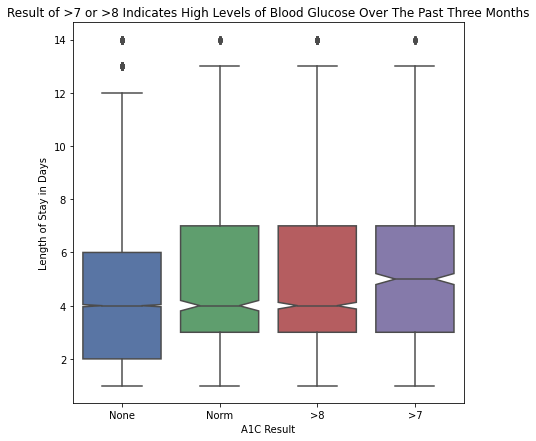

Patients with A1C greater than 7 are showing up in the higher
Length of Stay, higher A1C may require longer hospitalizations



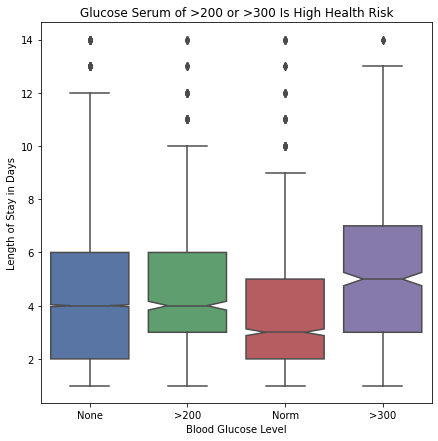

Patients with blood glucose higher than 300 are also showing higher
Length of Stay


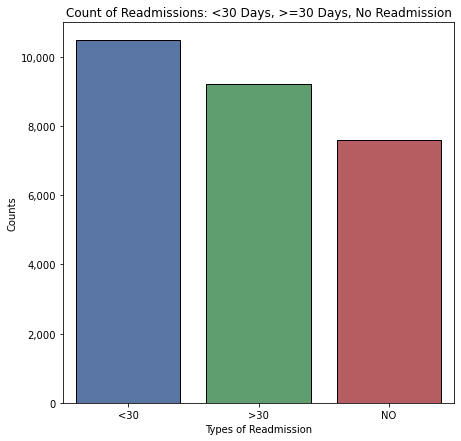

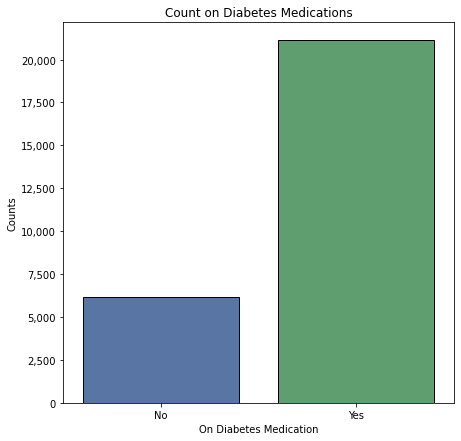

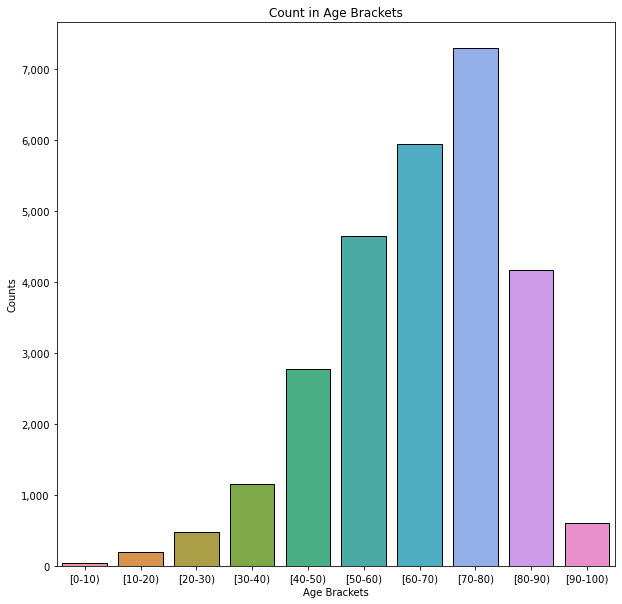

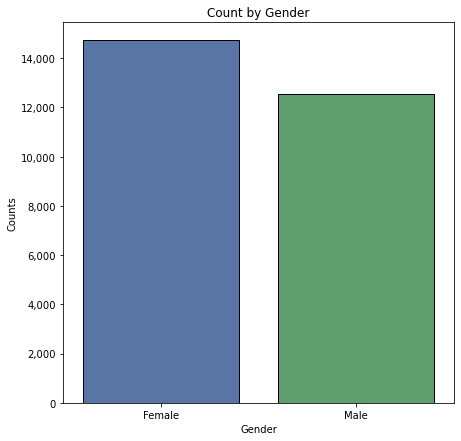

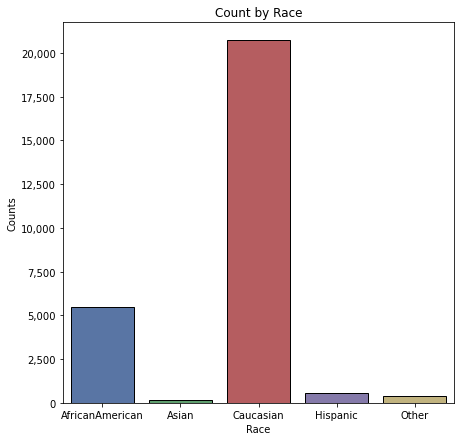

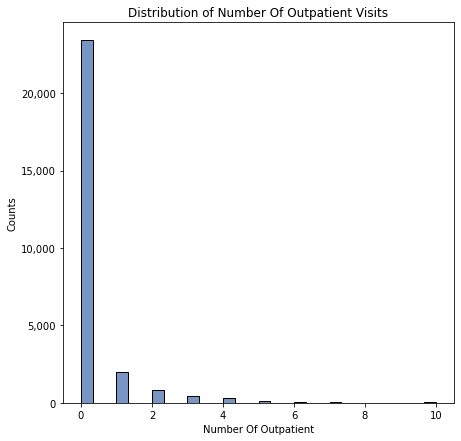

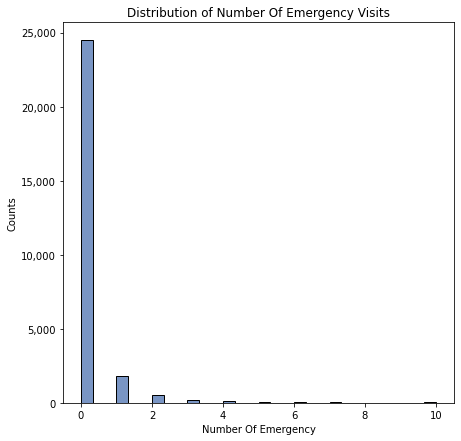

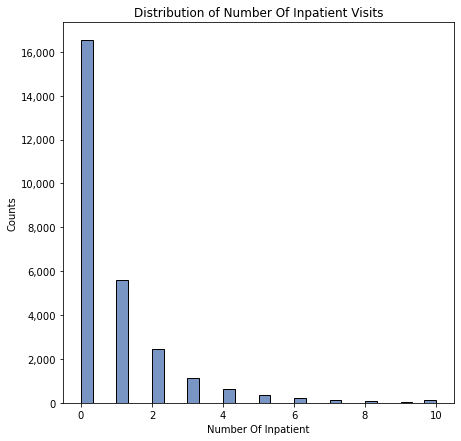

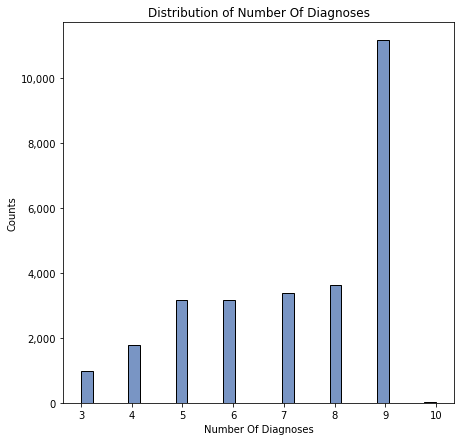

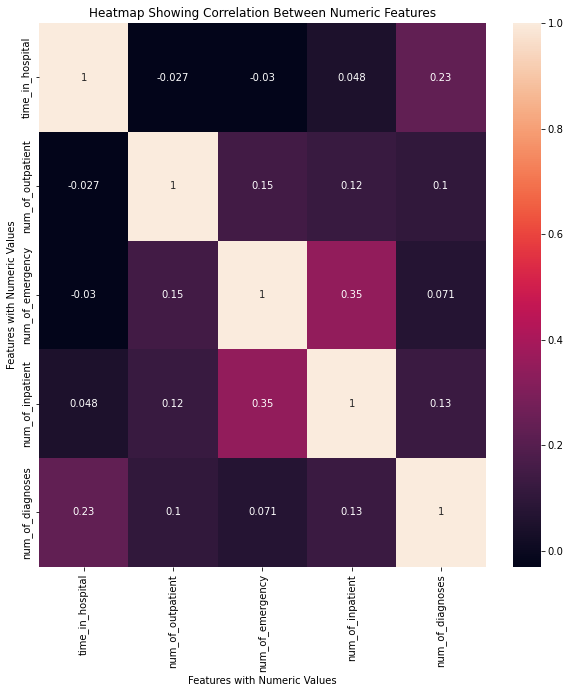

In [163]:
# Creating the key univariate plots on features
# create_plot function accepts the following parameters and generates a specific type of plot
#(xAxis-Data, yAxis-Data, xAxis-Label,yAxis-Label,Title of Plot, Plot type, Override default figsize)

# Create a number of Boxplots
create_plots('A1Cresult','time_in_hospital','A1C Result',
             'Length of Stay in Days',
             'Result of >7 or >8 Indicates High Levels of Blood Glucose Over The Past Three Months','Boxplot')
print("Patients with A1C greater than 7 are showing up in the higher\nLength of Stay, higher A1C may require longer hospitalizations\n")

create_plots('max_glu_serum','time_in_hospital',
             'Blood Glucose Level','Length of Stay in Days',
             'Glucose Serum of >200 or >300 Is High Health Risk','Boxplot')
print("Patients with blood glucose higher than 300 are also showing higher\nLength of Stay")

# Create a number of Barplots
create_plots('readmitted','discharge_group',
             'Types of Readmission','Counts',
             'Count of Readmissions: <30 Days, >=30 Days, No Readmission',
             'Barplot')

create_plots('diabetesMed','discharge_group',
             'On Diabetes Medication','Counts',
             'Count on Diabetes Medications','Barplot')

create_plots('age','discharge_group',
             'Age Brackets','Counts','Count in Age Brackets','Barplot',10)

create_plots('gender','discharge_group',
             'Gender','Counts','Count by Gender','Barplot')

create_plots('race','discharge_group',
             'Race','Counts','Count by Race','Barplot')

# Create a number of Histplots
histplot_features_list = ['num_of_outpatient',
                          'num_of_emergency','num_of_inpatient']
for plot in histplot_features_list:
    plotLbl = plot.replace("num_of_","number of ")
    plotLbl = plotLbl.title()
    create_plots(plot,'blank',
                 plotLbl,'Counts',
                 'Distribution of ' + plotLbl + ' Visits','Histplot')

histplot_features_list = ['num_of_diagnoses']
for plot in histplot_features_list:
    plotLbl = plot.replace("num_of_","number of ")
    plotLbl = plotLbl.title()
    create_plots(plot,'blank',
                 plotLbl,'Counts',
                 'Distribution of ' + plotLbl ,'Histplot')


# Create Heatmap to show correlation
create_plots('Features with Numeric Values',
             'Features with Numeric Values',
             'Features with Numeric Values',
             'Features with Numeric Values',
             'Heatmap Showing Correlation Between Numeric Features',
             'Heatmap',10)

# Start of Classifier and Model Development

In [164]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [165]:
# Establish X, y dataframe and data series respectively
y = df['readmitted']
X = df.drop(columns=['readmitted'])

In [166]:
# The dataset is imbalanced
df['readmitted'].value_counts(normalize=True)

<30    0.384021
>30    0.337951
NO     0.278028
Name: readmitted, dtype: float64

In [167]:
# Performing train test split and accounting for database imbalance in split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, shuffle = True)

In [168]:
ComparePredictions = pd.DataFrame(X_test)

In [169]:
predictions_array = np.array(y_test)

In [170]:
scaler = StandardScaler()

In [171]:
one_hot_encoder = OneHotEncoder(sparse =False, handle_unknown = 'ignore')

In [172]:
num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_include="object")

In [173]:
scaler_tuple = (scaler, num_selector)
ohe_tuple = (one_hot_encoder, cat_selector)

In [174]:
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)

In [175]:
column_transformer = make_column_transformer(scaler_tuple, ohe_tuple)

## Running Select Classifiers using GridSearchCV

In [176]:
def calculate_bestparams(myClf, myParams, myColTrans = column_transformer,X_train_fun = X_train, X_test_fun = X_test, y_train_fun = y_train, y_test_fun = y_test ):
    
    metrics_dict = {'y_test_actuals':{},'predictions':{},'classification_report':{},'confusion_matrix':{}}
    pipe = Pipeline([('col_trans',myColTrans),('clf',myClf)])
    gscv = GridSearchCV(pipe, myParams,verbose=0,)
    gscv.fit(X_train_fun, y_train_fun)
    predictions = gscv.best_estimator_.predict(X_test_fun)
    ClassificationReport = metrics.classification_report(y_test_fun, predictions, zero_division=1)
    ConfusionMatrix = metrics.confusion_matrix(y_test_fun, predictions,normalize='all')
    
    metrics_dict['y_test_actuals'] = y_test_fun
    metrics_dict['predictions'] = predictions
    metrics_dict['classification_report'] = ClassificationReport
    metrics_dict['confusion_matrix'] = ConfusionMatrix
    return metrics_dict

Identified five classifiers and a neural network model (3 iterations) to be used on the data. Making a total of 7 attempts to build a production worthy tool. The 8th is the Dummy Classifier and would never be used in production. The classifier or model that provides the highest recall rate on <30, will be likely recommended classifier or model

In [177]:
my_classifiers = {'DummyClf':{'name':"Dummy Classifier",'classifier':DummyClassifier(),
                              'param_grid':{'clf__constant': [None], 'clf__random_state': [None], 'clf__strategy': ['prior']}},
                  'LogRegClf':{'name':"Logistic Regression",'classifier':LogisticRegression(),
                               'param_grid':{'clf__C':[0.01,0.1],'clf__solver':['newton-cg','lbfgs'],'clf__max_iter':list(range(1900,2100,100))}},
                  'KNNClf':{'name':"K-Nearest Neighbors Classifier",'classifier':KNeighborsClassifier(),
                                'param_grid':{'clf__n_neighbors':[3,4],'clf__weights':['uniform','distance'],'clf__metric':['minkowski','euclidean']}},
                  'RndFstClf':{'name':"Random Forest Classifier",'classifier':RandomForestClassifier(),
                                'param_grid':{'clf__max_depth':[10,15],'clf__min_samples_leaf':[3,4],'clf__n_estimators':[50,100]}},
                    'LitGbmClf':{'name':"Light Gradient Boosting Framework",'classifier':LGBMClassifier(),
                                 'param_grid':{'clf__boosting_type':['gbdt','dart'],'clf__learning_rate':[0.01, 0.1],
                                               'clf__max_depth':[10,15],'clf__num_leaves':[3,4],'clf__n_estimators':[50,100],'verbose':[False]}}
                    }

In [178]:
%%time
for x,y in my_classifiers.items():
    print(f"Working on classifier: {y['name']} now.")
    my_classifiers[x]['metrics'] = calculate_bestparams(y['classifier'], y['param_grid'])

Working on classifier: Dummy Classifier now.
Working on classifier: Logistic Regression now.
Working on classifier: K-Nearest Neighbors Classifier now.
Working on classifier: Random Forest Classifier now.
Working on classifier: Light Gradient Boosting Framework now.
Wall time: 9min 11s


## Running Neural Network Models

In [179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [180]:
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F54F625880>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F54F625DC0>)])

In [181]:
X_train_P = column_transformer.transform(X_train)

In [182]:
X_test_P = column_transformer.transform(X_test)

In [183]:
y_train.replace({'<30':1,'>30':2,'NO':3},inplace = True)

In [184]:
y_test.replace({'<30':1,'>30':2,'NO':3},inplace = True)

In [185]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [187]:
y_train = np.delete(y_train,0,1)
y_test = np.delete(y_test,0,1)

In [188]:
input_shape = X_train_P.shape[1]

In [190]:
output_shape = y_train.shape[1]
output_activation = "sigmoid"
compile_loss_func = "binary_crossentropy"
if output_shape > 2:
    output_activation = "softmax"
    compile_loss_func = "categorical_crossentropy"

In [192]:
def run_model(neuron_units,dense_layer_count,num_patience,num_epochs,
              input_shape=input_shape,output_shape=output_shape,
              output_activation=output_activation,
              compile_loss_func=compile_loss_func, X_train_P_fun = X_train_P, 
              y_train_fun = y_train, X_test_P_fun = X_test_P, y_test_fun = y_test):
    """
    Credits
    -------
    Credit for docstring example: https://www.programiz.com/python-programming/docstrings
    Credit for early stopping min and best model save: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    
    Attributes
    ----------
    neuron_units    type: int desc: number of units in neuron in the hidden layer, decreases by half with each additional neuron added minimum is 1
    input_shape     type: int desc: number of columns used as features
    dense_layer_count   type: int desc: number of additional dense layers to add, maximum is 4
    output_shape    type: int desc: number of columns needed for classes
    output_activation   type: string desc: sigmoid when 2 classes or softmax when 3 or more classes
    compile_loss_func   type: string desc: binary_crossentropy when 2 classes or categorical_crossentropy when 3 or more classes 
    num_patience    type: int desc: number of epochs to run before training is stopped
    num_epochs      type: int desc: number of epochs to train data on
    """
    model = Sequential()
    # First hidden layer
    model.add(Dense(units = neuron_units, kernel_regularizer=l1_l2(l1=0.1, l2=0.1),bias_regularizer=l2(0.1),activity_regularizer=l2(0.1),
                        input_dim = input_shape,
                        activation = 'relu'))
    model.add(Dropout(0.2))
    dense_layer_count -= 1

    i = 0
    if dense_layer_count > 4:
        dense_layer_count = 4

    while i < dense_layer_count:
        if neuron_units < 1:
            neuron_units = 1
        else:
            neuron_units = sum(divmod(neuron_units,2))

        model.add(Dense(units = neuron_units,
                        activation = 'relu'))
        model.add(Dropout(0.2))
        i += 1
    print(f"Additional dense layers added {i}, making a total of {i+1} dense layers.")

    # Output layer
    model.add(Dense(units = output_shape, activation = output_activation))

    model.compile(loss = compile_loss_func, optimizer = 'adam',metrics=['acc'])
    early_stop_min = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = num_patience)

    history = model.fit(X_train_P_fun, y_train_fun, validation_data=(X_test_P_fun, y_test_fun), epochs = num_epochs, callbacks = [early_stop_min])
    predictions = model.predict(X_test_P_fun)

    y_test_actuals = np.argmax(y_test_fun, axis=-1)
    predictions = np.argmax(predictions, axis=-1)

    ConfusionMatrix = metrics.confusion_matrix(y_test_actuals, predictions,normalize='all')
    return history, predictions, y_test_actuals, ConfusionMatrix

In [193]:
my_models = {'Model1_Mdl':{'name':'Neural Network Model',
                           'param_grid':{'neuron_units':350,'dense_layer_count':1,'num_patience':10,'num_epochs':200}},
             'Model2_Mdl':{'name':'Neural Network Model',
                           'param_grid':{'neuron_units':300,'dense_layer_count':1,'num_patience':10,'num_epochs':200}},
             'Model3_Mdl':{'name':'Neural Network Model',
                           'param_grid':{'neuron_units':250,'dense_layer_count':1,'num_patience':10,'num_epochs':200}}}

In [194]:
%%time
ComparePredictions['readmitted'] = predictions_array
for x,y in my_models.items():
    print(x)
    my_models[x]['history'], my_models[x]['predictions'], my_models[x]['y_test_actuals'], my_models[x]['confusion_matrix'] = run_model(y['param_grid']['neuron_units'],
                                        y['param_grid']['dense_layer_count'],y['param_grid']['num_patience'],y['param_grid']['num_epochs'])
    
    column_name = x + "_Preds"

    ComparePredictions[column_name] = my_models[x]['predictions']
    ComparePredictions.replace({column_name:{0:'<30',1:'>30',2:'NO'}},inplace=True)

Model1_Mdl
Additional dense layers added 0, making a total of 1 dense layers.
Epoch 1/200
640/640 [==============================] - 3s 5ms/step - loss: 58.7669 - acc: 0.3827 - val_loss: 7.9882 - val_acc: 0.3841
Epoch 2/200
640/640 [==============================] - 3s 4ms/step - loss: 7.9604 - acc: 0.3840 - val_loss: 7.8582 - val_acc: 0.3841
Epoch 3/200
640/640 [==============================] - 3s 4ms/step - loss: 7.9185 - acc: 0.3840 - val_loss: 7.9164 - val_acc: 0.3841
Epoch 4/200
640/640 [==============================] - 3s 4ms/step - loss: 7.9415 - acc: 0.3840 - val_loss: 7.9204 - val_acc: 0.3841
Epoch 5/200
640/640 [==============================] - 3s 5ms/step - loss: 7.9574 - acc: 0.3840 - val_loss: 7.9093 - val_acc: 0.3841
Epoch 6/200
640/640 [==============================] - 4s 6ms/step - loss: 7.9661 - acc: 0.3840 - val_loss: 7.9783 - val_acc: 0.3841
Epoch 7/200
640/640 [==============================] - 3s 5ms/step - loss: 7.9728 - acc: 0.3840 - val_loss: 7.9469 - val_ac

Classification Report for: Dummy Classifier
              precision    recall  f1-score   support

         <30       0.38      1.00      0.55      2620
         >30       1.00      0.00      0.00      2305
          NO       1.00      0.00      0.00      1897

    accuracy                           0.38      6822
   macro avg       0.79      0.33      0.18      6822
weighted avg       0.76      0.38      0.21      6822



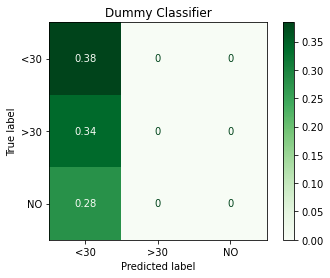



Classification Report for: Logistic Regression
              precision    recall  f1-score   support

         <30       0.59      0.67      0.63      2620
         >30       0.46      0.41      0.43      2305
          NO       0.48      0.46      0.47      1897

    accuracy                           0.52      6822
   macro avg       0.51      0.51      0.51      6822
weighted avg       0.52      0.52      0.52      6822



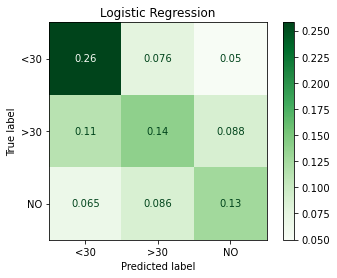



Classification Report for: K-Nearest Neighbors Classifier
              precision    recall  f1-score   support

         <30       0.53      0.62      0.57      2620
         >30       0.41      0.39      0.40      2305
          NO       0.40      0.34      0.37      1897

    accuracy                           0.46      6822
   macro avg       0.45      0.45      0.44      6822
weighted avg       0.45      0.46      0.45      6822



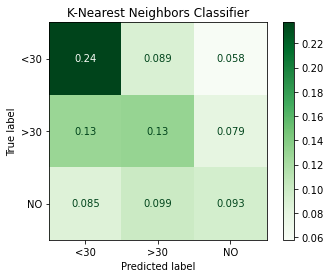



Classification Report for: Random Forest Classifier
              precision    recall  f1-score   support

         <30       0.53      0.78      0.63      2620
         >30       0.44      0.39      0.42      2305
          NO       0.55      0.28      0.37      1897

    accuracy                           0.51      6822
   macro avg       0.51      0.48      0.47      6822
weighted avg       0.51      0.51      0.49      6822



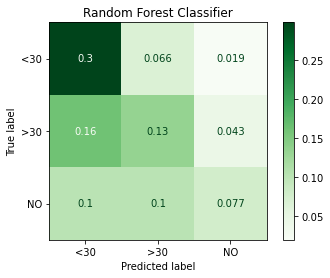



Classification Report for: Light Gradient Boosting Framework
              precision    recall  f1-score   support

         <30       0.58      0.68      0.63      2620
         >30       0.46      0.37      0.41      2305
          NO       0.47      0.47      0.47      1897

    accuracy                           0.52      6822
   macro avg       0.50      0.51      0.50      6822
weighted avg       0.51      0.52      0.51      6822



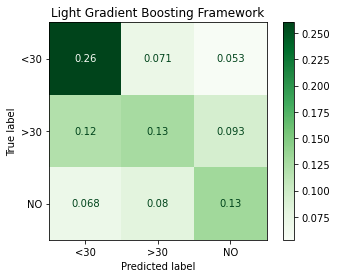

In [196]:
for x,y in my_classifiers.items():
    
    print(f"Classification Report for: {y['name']}")
    print(y['metrics']['classification_report'])

    cm = y['metrics']['confusion_matrix']
    disp = ConfusionMatrixDisplay(cm,display_labels=["<30",">30","NO"]);
    
    disp.plot(cmap='Greens')
    disp.ax_.set_title(y['name'])
    plt.show()
    print("\n")

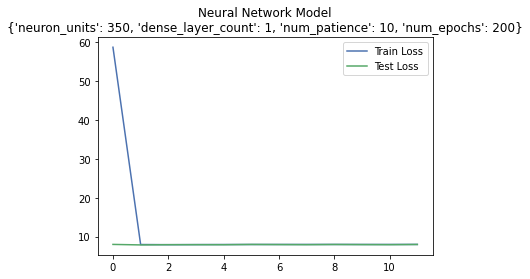

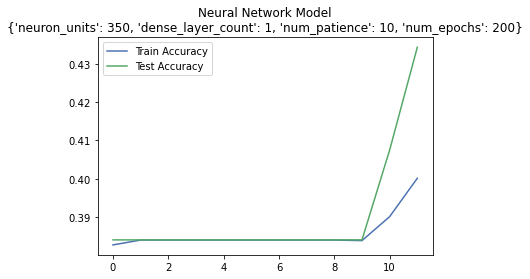



Classification Report for: Neural Network Model
{'neuron_units': 350, 'dense_layer_count': 1, 'num_patience': 10, 'num_epochs': 200}
              precision    recall  f1-score   support

         <30       0.47      0.81      0.59      2620
         >30       0.37      0.36      0.36      2305
          NO       1.00      0.00      0.00      1897

    accuracy                           0.43      6822
   macro avg       0.61      0.39      0.32      6822
weighted avg       0.58      0.43      0.35      6822



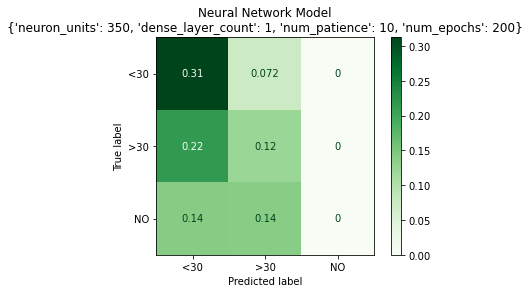

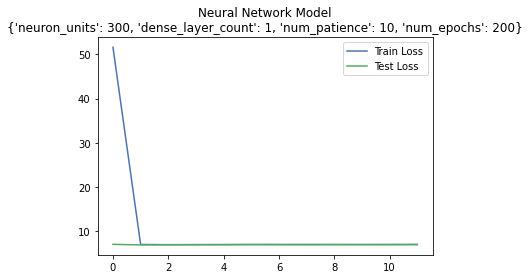

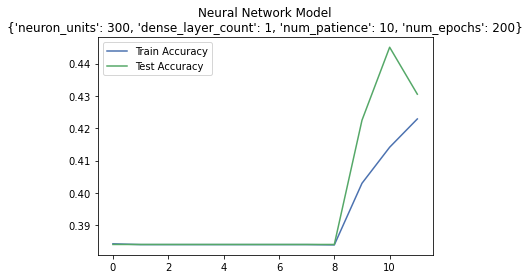



Classification Report for: Neural Network Model
{'neuron_units': 300, 'dense_layer_count': 1, 'num_patience': 10, 'num_epochs': 200}
              precision    recall  f1-score   support

         <30       0.46      0.86      0.60      2620
         >30       0.36      0.30      0.33      2305
          NO       1.00      0.00      0.00      1897

    accuracy                           0.43      6822
   macro avg       0.61      0.39      0.31      6822
weighted avg       0.58      0.43      0.34      6822



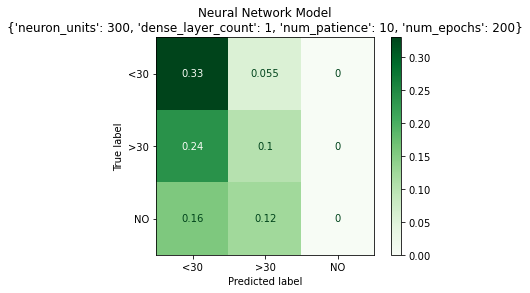

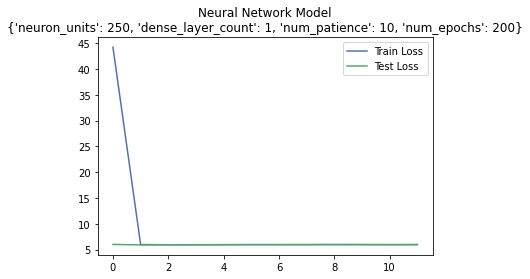

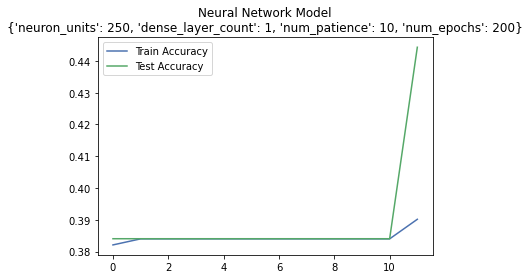



Classification Report for: Neural Network Model
{'neuron_units': 250, 'dense_layer_count': 1, 'num_patience': 10, 'num_epochs': 200}
              precision    recall  f1-score   support

         <30       0.50      0.78      0.61      2620
         >30       0.37      0.43      0.40      2305
          NO       1.00      0.00      0.00      1897

    accuracy                           0.44      6822
   macro avg       0.62      0.40      0.33      6822
weighted avg       0.59      0.44      0.37      6822



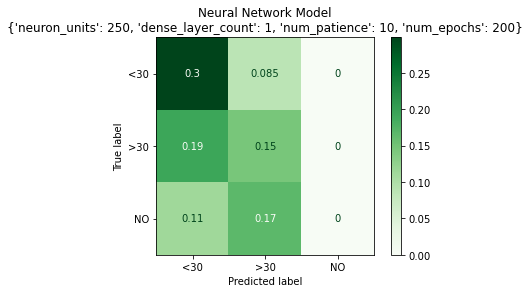

In [198]:
for x, y in my_models.items():
    axs = sns.lineplot(data = y['history'].history['loss'], label = 'Train Loss')
    axs = sns.lineplot(data = y['history'].history['val_loss'], label = 'Test Loss')
    myTitle = str(y['name']) + "\n" + str(y['param_grid'])
    axs.set_title(label=myTitle)
    plt.show();

    axs = sns.lineplot(data = y['history'].history['acc'], label = 'Train Accuracy')
    axs = sns.lineplot(data = y['history'].history['val_acc'], label = 'Test Accuracy')
    myTitle = str(y['name']) + "\n" + str(y['param_grid'])
    axs.set_title(label=myTitle)
    plt.show();
    print("\n")

    print(f"Classification Report for: {myTitle}")
    cr = metrics.classification_report(y['y_test_actuals'], y['predictions'],zero_division=1,target_names=["<30",">30","NO"])
    print(cr)

    cm = y['confusion_matrix']
    disp = ConfusionMatrixDisplay(cm, display_labels=["<30",">30","NO"])
    disp.plot(cmap='Greens')
    disp.ax_.set_title(myTitle)
    plt.show()
    print("\n")

# Recommendation is the Neural Network Model with the following parameters:
* Number of neuron units(neuron_units) : 300
* Number of layers(dense_layer_count) : 1
* Number of patience(num_patience) : 10
* Number of epochs(num_epochs) : 200

In [199]:
# Export predictions file for close inspection if needed.
path = 'c:\\'
os.chdir(path)
ComparePredictions.to_csv( filepath + "DiabetesReadmitsCompare.csv")

# Start of Citation and References Section

1) Source of data is UCI Machine Learning Repository, URL is: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

2) The data is provided by the Virigina Commonwealth University, on Diabetes related admission from 130-US hospitals for years 1999 through 2008.

3) Target is predicting classifying admissions as re-admit; less than 30, more than 30 or none. 

4) This is a classification problem.

5) Data has 50 columns and 6) 100,000 rows of data

7) Dataset has a lot of columns, it is going to test my healthcare background. One of the reasons why I choose this dataset, I have done a lot of work on clinical outcomes.

# Citations:


1. List of features and descriptions: https://www.hindawi.com/journals/bmri/2014/781670/tab1/
2. Open Access article: https://www.hindawi.com/journals/bmri/2014/781670/
3. Citation: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records", BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670